In [1]:
import MetaTrader5 as mt5
import pandas as pd
import time
from datetime import datetime, timedelta
import ta

In [2]:

def connect_to_mt5():
    if not mt5.initialize():
        print("Failed to initialize the Metatrader 5 library.")
        return False
    print("Connected to MetaTrader 5")
    return True

In [3]:

def get_data(symbol, timeframe, start_date, end_time):
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_time)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

In [7]:

def get_sma(data, period):
    calc_sma = data['close'].tail(period)
    sma = calc_sma.mean()
    return sma


In [8]:
def get_prev_sma(data, period):
    prev_sma = data['close'].rolling(period).mean()
    return prev_sma


In [9]:
def market_order(symbol, volume, order_type, deviation=20, magic=261200):
    order_type_dict = {
        'buy'  : mt5.ORDER_TYPE_BUY,
        'sell'  : mt5.ORDER_TYPE_SELL
    }
    price_dict = {
        'buy' : mt5.symbol_info_tick(symbol).ask,
        'sell' : mt5.symbol_info_tick(symbol).bid
    }
    
    if order_type == 'buy':
        sl_price = price_dict['buy'] - (200 * mt5.symbol_info(symbol).point)
        tp_price = price_dict['buy'] + (500 * mt5.symbol_info(symbol).point)
    elif order_type == 'sell':
        sl_price = price_dict['sell'] + (200 * mt5.symbol_info(symbol).point)
        tp_price = price_dict['sell'] - (500 * mt5.symbol_info(symbol).point)
    else:
        raise ValueError("Invalid order type.")
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume,  # FLOAT
        "type": order_type_dict[order_type],
        "price": price_dict[order_type],
        "sl": sl_price,  # FLOAT
        "tp": tp_price,  # FLOAT
        "deviation": deviation,  # INTEGER
        "magic": magic,  # INTEGER
        "comment": "my_first_strat",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    order_result = mt5.order_send(request)
    return order_result

In [11]:
def main():
    symbol = 'XAUUSD'
    timeframe = mt5.TIMEFRAME_M5
    volume = 0.1
    
    if not connect_to_mt5():
        return
    
    while True:
        account_info = mt5.account_info()
        print(datetime.now(),
              '| Login: ', account_info.login,
              '| Balance: ', account_info.balance,
              '| Equity: ' , account_info.equity,
              '| Profit: ', account_info.profit)
        
        current_time = datetime.utcfromtimestamp(mt5.symbol_info(symbol).time)
        print(current_time)
        start_time = current_time - timedelta(days=7)
        end_time = current_time

        data = get_data(symbol, timeframe, start_time, end_time)
        if len(data) < 120:  
            print("Not enough data.")
            time.sleep(60)
            continue
        
        fast_ma = get_sma(data,  20).iloc[-1]
        slow_ma = get_sma(data, 120).iloc[-1]
        
        # Check if there are open positions
        positions_total = mt5.positions_total()
        
        # Keep track of current position
        in_position = positions_total > 0
        
        prev_fast_ma = get_sma(data, 20).iloc[-2]
        prev_slow_ma = get_sma(data, 120).iloc[-2]


        # Check conditions and place trades
        if not in_position: 
            if (fast_ma > slow_ma) and (prev_fast_ma <= prev_slow_ma):
                market_order(symbol, volume, 'buy')
                print('Buy signal detected')
                in_position = True

            elif (fast_ma < slow_ma) and (prev_fast_ma >= prev_slow_ma):
                market_order(symbol, volume, 'sell')
                print('Sell signal detected')
                in_position = True
        output1 = (fast_ma > slow_ma) and (prev_fast_ma <= prev_slow_ma)
        output2 = (fast_ma < slow_ma) and (prev_fast_ma >= prev_slow_ma)
        
        print(f'Fastma :{fast_ma}')
        print(f'Slowma :{slow_ma}')
        print(f'Prev Fastma :{prev_fast_ma}')
        print(f'Prev Slowma :{prev_slow_ma}')
        print(f'Buy Signal :{output1}')
        print(f'Sell Signal :{output2}')  
        
        time.sleep(300)  # Check every 5 minutes


In [3]:
if __name__ == "__main__":
    main()

NameError: name 'main' is not defined

In [11]:
mt5.initialize()

True

In [34]:
current_time = datetime.utcfromtimestamp(mt5.symbol_info('XAUUSD').time)
print(current_time)
start_time = current_time - timedelta(days=7)
print(start_time)
end_time = current_time + timedelta(hours= 1)
print(end_time)
data = get_data('XAUUSD', mt5.TIMEFRAME_M5, start_time, end_time)
data

2024-04-01 14:06:20
2024-03-25 14:06:20
2024-04-01 15:06:20


,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2024-03-25 14:10:00,2169.44,2171.19,2169.44,2171.16,400,5,0
2024-03-25 14:15:00,2171.19,2171.90,2170.78,2171.22,442,5,0
2024-03-25 14:20:00,2171.35,2171.54,2170.98,2171.01,361,5,0
2024-03-25 14:25:00,2171.01,2171.72,2170.75,2171.48,307,5,0
2024-03-25 14:30:00,2171.48,2171.64,2170.18,2170.34,393,5,0
...,...,...,...,...,...,...,...
2024-04-01 13:45:00,2249.71,2249.96,2248.76,2249.21,344,5,0
2024-04-01 13:50:00,2249.21,2249.84,2245.65,2246.61,719,0,0
2024-04-01 13:55:00,2246.61,2247.92,2246.61,2247.86,427,5,0


### Martingale


In [43]:

symbol = 'XAUUSD'
volume = 0.1

history_orders = mt5.history_deals_get(datetime(2024,1,1),datetime.now(), symbol ="XAUUSD")
history_orders[-1].profit

51.0

In [16]:
def get_data(symbol, timeframe, start_date, end_time):
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_time)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df


data = get_data('XAUUSD', mt5.TIMEFRAME_M5, datetime(2024,4,1), datetime.now())
data


,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2024-04-01 01:05:00,2239.85,2243.13,2238.45,2242.06,958,4,0
2024-04-01 01:10:00,2241.89,2242.38,2238.42,2240.49,713,4,0
2024-04-01 01:15:00,2240.49,2241.22,2238.13,2239.85,731,4,0
2024-04-01 01:20:00,2239.93,2241.80,2239.64,2241.50,442,9,0
2024-04-01 01:25:00,2241.50,2242.17,2240.96,2241.78,430,4,0
...,...,...,...,...,...,...,...
2024-04-12 06:30:00,2388.22,2388.55,2386.77,2387.91,1027,4,0
2024-04-12 06:35:00,2387.98,2389.02,2385.50,2386.38,1091,4,0
2024-04-12 06:40:00,2386.39,2386.71,2383.97,2384.59,937,4,0


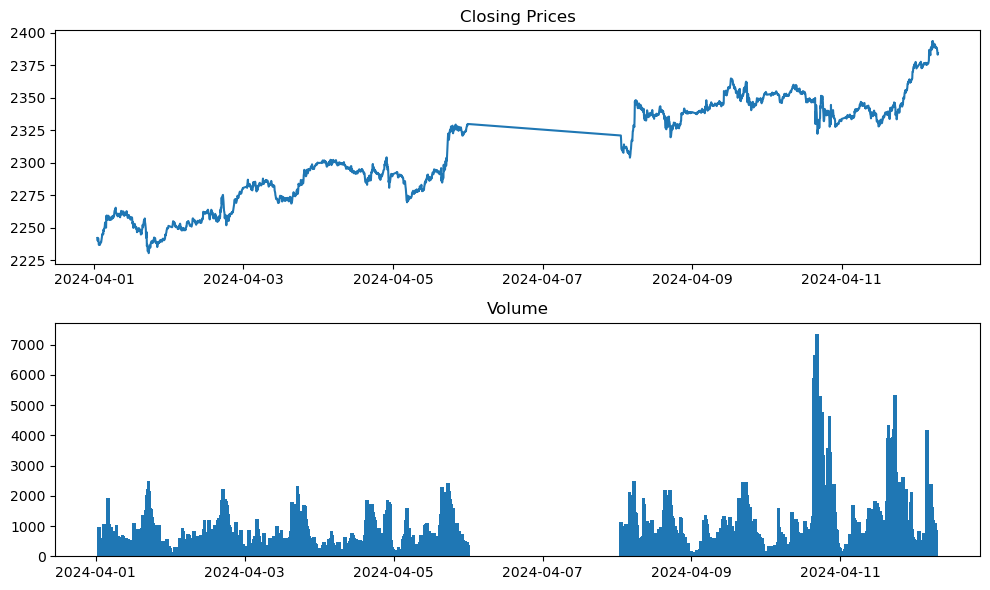

In [18]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot closing prices
axs[0].plot(data.index, data['close'])
axs[0].set_title('Closing Prices')
axs[0].grid(False)

# Plot bar chart of tick volume
axs[1].bar(data.index, data['tick_volume'], width=0.05)  # Adjust the width of the bars as needed
axs[1].set_title('Volume')
axs[1].grid(False)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()
